In [7]:
# 02_analise_exploratoria_dados.ipynb 
# ----------------------------------------------------
# %% --------------------------------------------------------------------
# IMPORTAR BIBLIOTECAS
# -----------------------------------------------------------------------
# • pyspark – processamento distribuído
# • pandas, matplotlib, seaborn – gráficos estáticos leves
# • plotly, folium – visualizações interactivas
# • ydata_profiling – relatório de profiling completo (sobre amostra)
# ----------------------------------------------------------------------------
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import (
    col, desc, hour, dayofweek, to_timestamp, unix_timestamp
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from ydata_profiling import ProfileReport
from pathlib import Path

# Configura matplotlib para ecrãs retina (opcional)
plt.rcParams["figure.dpi"] = 110

# %% --------------------------------------------------------------------
# INICIALIZAR OU RECUPERAR SPARK SESSION
# -----------------------------------------------------------------------
# Usa o modo local[*] por omissão; no cluster remove .master("local[*]")
# O appName ajuda a identificar no UI do Spark.
# -----------------------------------------------------------------------
spark = (
    SparkSession.builder
    .appName("ChicagoCrimeEDA")
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "8g")\
    .getOrCreate()
)

# %% --------------------------------------------------------------------
# LEITURA DO PARQUET *LIMPO* (gerado no notebook 01)
# -----------------------------------------------------------------------
# • Converte as colunas de data para timestamp.
# • Mantém o schema produzido na etapa de cleaning.
# -----------------------------------------------------------------------
DATA_PATH = "../dados/chicago_crime.parquet"  #
DATA_PATH_SMALL = "../dados/chicago_crime_small.parquet"  # 

df = (
    spark.read.parquet(DATA_PATH)
)
df_small = (
    spark.read.parquet(DATA_PATH_SMALL)
)

In [ ]:
profile_title = 'chicago_crime'
df_small_pd = df_small.toPandas()               # Spark ainda activo aqui
df_small_pd["Date"]       = pd.to_datetime(df_small_pd["Date"], errors="coerce")
df_small_pd["Updated_On"] = pd.to_datetime(df_small_pd["Updated_On"], errors="coerce")

profile_report = ProfileReport(
    df_small_pd,
    title=profile_title,
    infer_dtypes=False,
    interactions=None,
    missing_diagrams=None,
    correlations={
        "auto": {"calculate": False},
        "pearson": {"calculate": False},
        "spearman": {"calculate": False},
    },
    html={"inline": False},  # Desativa a renderização inline de widgets
)

profile_report_file =  "../relatorios/profile_chicago_crime_after.html"
profile_report.to_file(Path(profile_report_file))
profile_report_file

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'n_invalid_dates'

Quantis (1 %, 50 %, 99 %): [Timestamp('2001-01-01 01:00:00'), Timestamp('2010-03-01 01:00:00'), Timestamp('2024-07-03 12:58:00')]
+-------------------+-------+
|Primary_Type       |count  |
+-------------------+-------+
|THEFT              |1704082|
|BATTERY            |1476454|
|CRIMINAL DAMAGE    |921939 |
|NARCOTICS          |752603 |
|ASSAULT            |534684 |
|OTHER OFFENSE      |498732 |
|BURGLARY           |433395 |
|MOTOR VEHICLE THEFT|406303 |
|DECEPTIVE PRACTICE |364719 |
|ROBBERY            |305234 |
+-------------------+-------+
only showing top 10 rows

+------+-------+
|Arrest|  count|
+------+-------+
|  true|2067330|
| false|6010480|
+------+-------+

+------------------------------+-------+
|Location_Description          |count  |
+------------------------------+-------+
|STREET                        |2117288|
|RESIDENCE                     |1344471|
|APARTMENT                     |939367 |
|SIDEWALK                      |745486 |
|OTHER                         |26

/tmp/ipykernel_6757/2090275499.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Arrest", data=sample_pdf, palette="pastel")


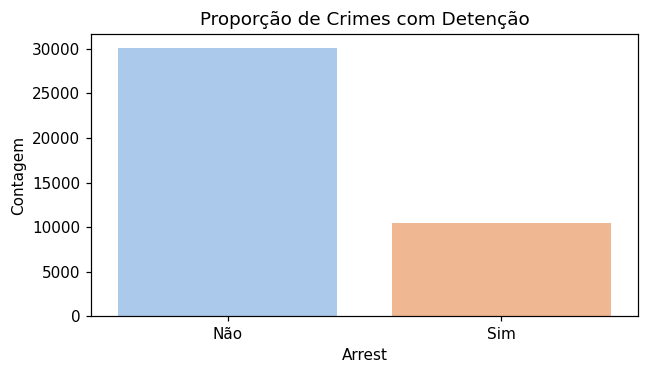

/tmp/ipykernel_6757/2090275499.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=loc_top.index, x=loc_top.values, palette="rocket")


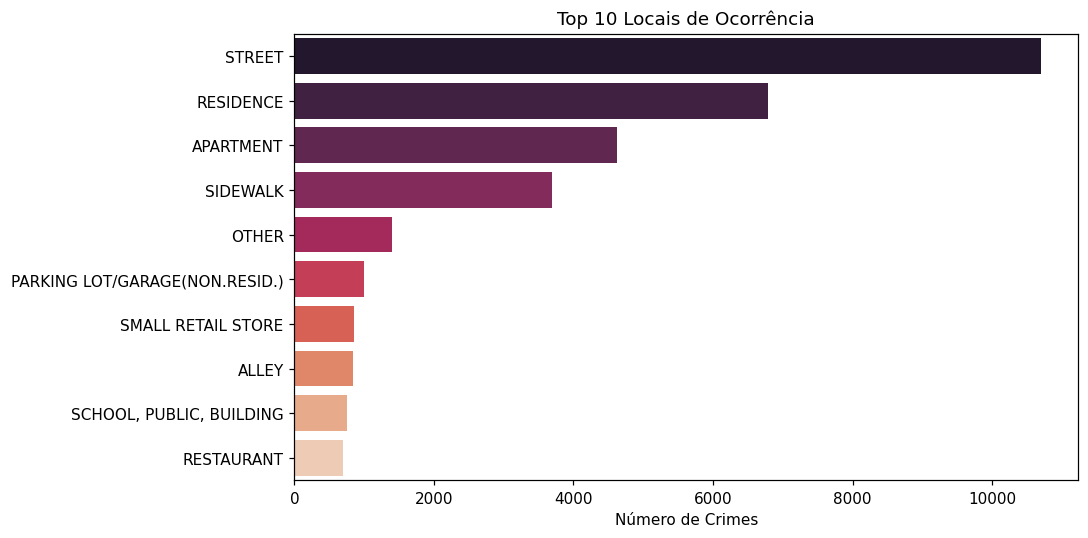

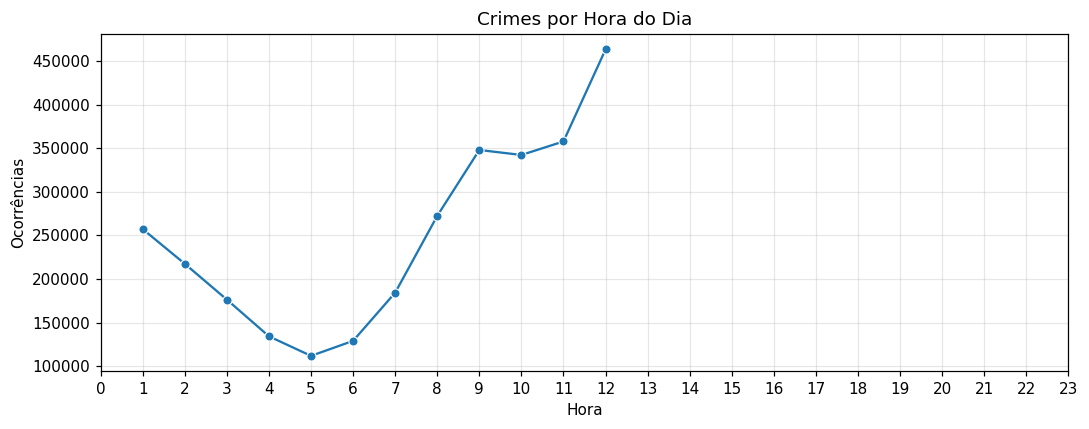

/tmp/ipykernel_6757/2090275499.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_df, x="DayOfWeek", y="count", palette="mako")


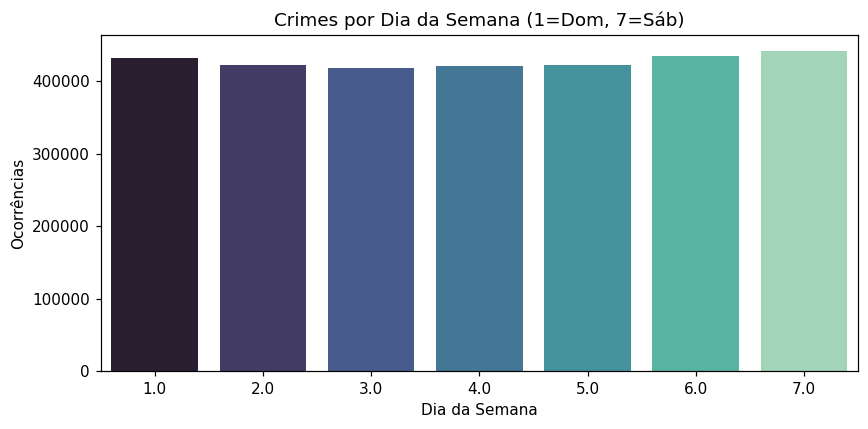

/tmp/ipykernel_6757/2090275499.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=arr_top.index, x=arr_top.values, palette="flare")


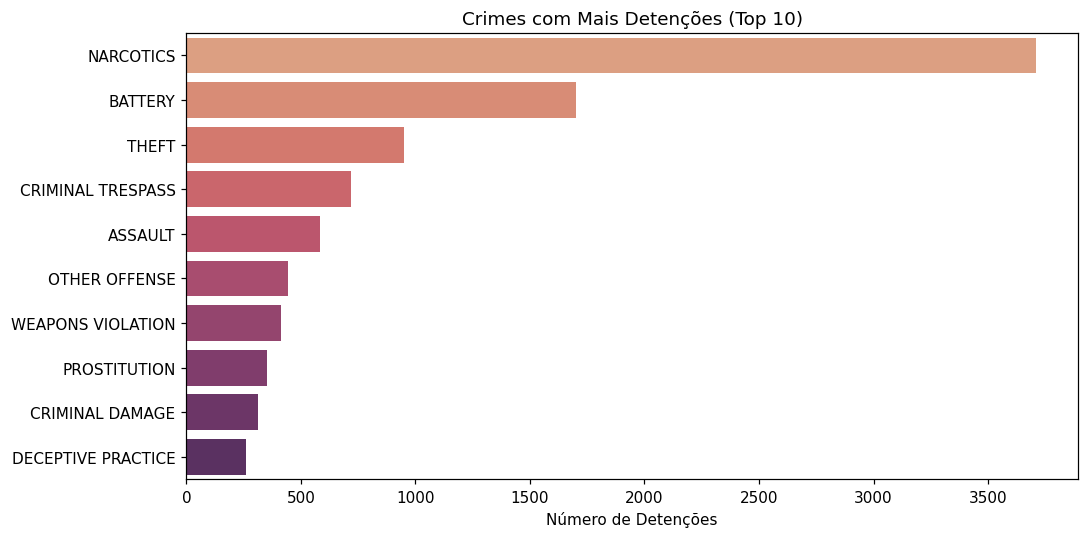

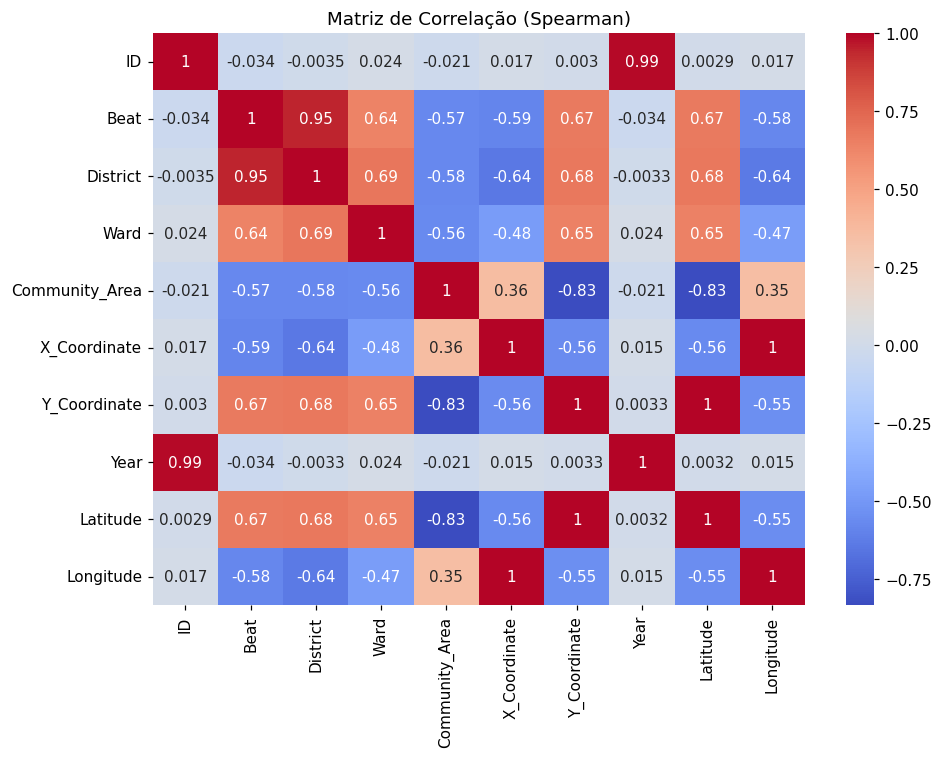

[INFO] SparkSession encerrada.


In [3]:
# %% --------------------------------------------------------------------
# QUICK‑CHECK: QUANTIS DA VARIÁVEL TEMPORAL
# -----------------------------------------------------------------------
# 1 %  / 50 % / 99 % ajudam a detectar datas aberrantes.
# -----------------------------------------------------------------------
df_numeric = df.withColumn("DateSeconds", unix_timestamp("Date"))
q_secs = df_numeric.approxQuantile("DateSeconds", [0.01, 0.5, 0.99], 0.01)
q_timestamps = [pd.to_datetime(q, unit="s") for q in q_secs]
print("Quantis (1 %, 50 %, 99 %):", q_timestamps)

# %% --------------------------------------------------------------------
# AGREGAÇÕES PRINCIPAIS (Spark ⇒ resistente a volume)
# -----------------------------------------------------------------------
crime_type_counts = (
    df.groupBy("Primary_Type").count().orderBy(desc("count"))
)
arrest_counts = df.groupBy("Arrest").count()
location_counts = (
    df.groupBy("Location_Description").count().orderBy(desc("count"))
)
hour_counts = (
    df.withColumn("Hour", hour("Date")).groupBy("Hour").count().orderBy("Hour")
)
dow_counts = (
    df.withColumn("DayOfWeek", dayofweek("Date")).groupBy("DayOfWeek").count().orderBy("DayOfWeek")
)
arrest_crime_counts = (
    df.filter(col("Arrest") == True)
      .groupBy("Primary_Type").count().orderBy(desc("count"))
)

# Mostra tabelas no console Spark (útil para debug)
crime_type_counts.show(10, truncate=False)
arrest_counts.show()
location_counts.show(10, truncate=False)

# %% --------------------------------------------------------------------
# AMOSTRA DE 0.5 % PARA GRÁFICOS (≈ 35 k linhas num dataset de 7 M)
# -----------------------------------------------------------------------
# Mantém interactividade sem rebentar memória/tempo.
# -----------------------------------------------------------------------
sample_pdf = df.sample(False, 0.005, seed=42).toPandas()
sample_pdf["Date"] = pd.to_datetime(sample_pdf["Date"])

# %% --------------------------------------------------------------------
# GRÁFICOS ESTÁTICOS (Matplotlib + Seaborn)
# -----------------------------------------------------------------------
# 1. Proporção de crimes com detenção
plt.figure(figsize=(6, 3.5))
sns.countplot(x="Arrest", data=sample_pdf, palette="pastel")
plt.title("Proporção de Crimes com Detenção")
plt.xticks([0, 1], ["Não", "Sim"])
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

# 2. Top‑10 locais de ocorrência
plt.figure(figsize=(10, 5))
loc_top = sample_pdf["Location_Description"].value_counts().nlargest(10)
sns.barplot(y=loc_top.index, x=loc_top.values, palette="rocket")
plt.title("Top 10 Locais de Ocorrência")
plt.xlabel("Número de Crimes")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 3. Distribuição horária
plt.figure(figsize=(10, 4))
hr_df = hour_counts.toPandas()
sns.lineplot(data=hr_df, x="Hour", y="count", marker="o")
plt.title("Crimes por Hora do Dia")
plt.xlabel("Hora")
plt.ylabel("Ocorrências")
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Crimes por dia da semana
plt.figure(figsize=(8, 4))
dow_df = dow_counts.toPandas()
sns.barplot(data=dow_df, x="DayOfWeek", y="count", palette="mako")
plt.title("Crimes por Dia da Semana (1=Dom, 7=Sáb)")
plt.xlabel("Dia da Semana")
plt.ylabel("Ocorrências")
plt.tight_layout()
plt.show()

# 5. Tipos de crime com detenção (top 10)
plt.figure(figsize=(10, 5))
arr_top = sample_pdf[sample_pdf["Arrest"] == True]["Primary_Type"].value_counts().nlargest(10)
sns.barplot(y=arr_top.index, x=arr_top.values, palette="flare")
plt.title("Crimes com Mais Detenções (Top 10)")
plt.xlabel("Número de Detenções")
plt.ylabel("")
plt.tight_layout()
plt.show()

# %% --------------------------------------------------------------------
# HEATMAP DE CORRELAÇÃO (Spearman) – apenas colunas numéricas
# -----------------------------------------------------------------------
numeric_cols = sample_pdf.select_dtypes(include="number").columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(9, 7))
    sns.heatmap(sample_pdf[numeric_cols].corr(method="spearman"), cmap="coolwarm", annot=True)
    plt.title("Matriz de Correlação (Spearman)")
    plt.tight_layout()
    plt.show()

# %% --------------------------------------------------------------------
# SÉRIE TEMPORAL INTERACTIVA (Plotly)
# -----------------------------------------------------------------------
ts = (
    sample_pdf.groupby(sample_pdf["Date"].dt.to_period("M")).size().reset_index(name="count")
)
ts["Date"] = ts["Date"].dt.to_timestamp()
fig = px.line(ts, x="Date", y="count", title="Crimes por Mês", labels={"count": "Ocorrências"})
fig.update_layout(template="plotly_white")
fig.show()

# %% --------------------------------------------------------------------
# MAPA INTERACTIVO (Folium) – plot dos pontos amostrados
# -----------------------------------------------------------------------
m = folium.Map(location=[41.85, -87.65], zoom_start=11, tiles="CartoDB positron")
for _, row in sample_pdf.iterrows():
    lat, lon = row.get("Latitude"), row.get("Longitude")
    if pd.notnull(lat) and pd.notnull(lon):
        folium.CircleMarker(location=[lat, lon], radius=1.3, color="red", opacity=0.6, fill=True).add_to(m)

# No notebook basta terminar a célula com `m` para exibir o mapa
m

# %% --------------------------------------------------------------------
# FINALIZAR SPARK
# -----------------------------------------------------------------------
spark.stop()
print("[INFO] SparkSession encerrada.")